In [1]:
from typing import Union
import numpy as np
import pandas as pd
import numpy.typing as npt
from typing import Tuple
from tqdm import tqdm
from matplotlib import pyplot as plt
from simulations.stochastic_models import StochasticModels

from utility.math_equations import (
    compute_currrent_step_log_price,
    compute_next_step_log_vol,
)

from filters.kalman_filter import LinearKalmanFilterND
from filters.unscented_kalman_filter import UnscentedKalmanFilter

In [7]:
# Seed for reproducibility
# np.random.seed(42)

t, prices, vol_sto = StochasticModels.simulate_heston_process_with_jump(5,100)

df = pd.DataFrame({"t": t, "prices": prices, "vol_sto": vol_sto})
df["returns"] = df.prices.pct_change().fillna(0)
df["vol"] = df.returns.rolling(7).std()
df = df.dropna()
df

,t,prices,vol_sto,returns,vol
6,0.023810,111.500966,0.395159,0.008757,0.025439
7,0.027778,116.670471,0.351858,0.046363,0.026603
8,0.031746,108.090947,0.353643,-0.073536,0.043852
9,0.035714,107.148429,0.328550,-0.008720,0.041611
10,0.039683,98.559306,0.339461,-0.080161,0.053071
...,...,...,...,...,...
1256,4.984127,177.028439,0.421626,-0.007211,0.039337
1257,4.988095,167.973695,0.450397,-0.051149,0.041283
1258,4.992063,163.339685,0.466694,-0.027588,0.035316
1259,4.996032,161.336321,0.521454,-0.012265,0.034377


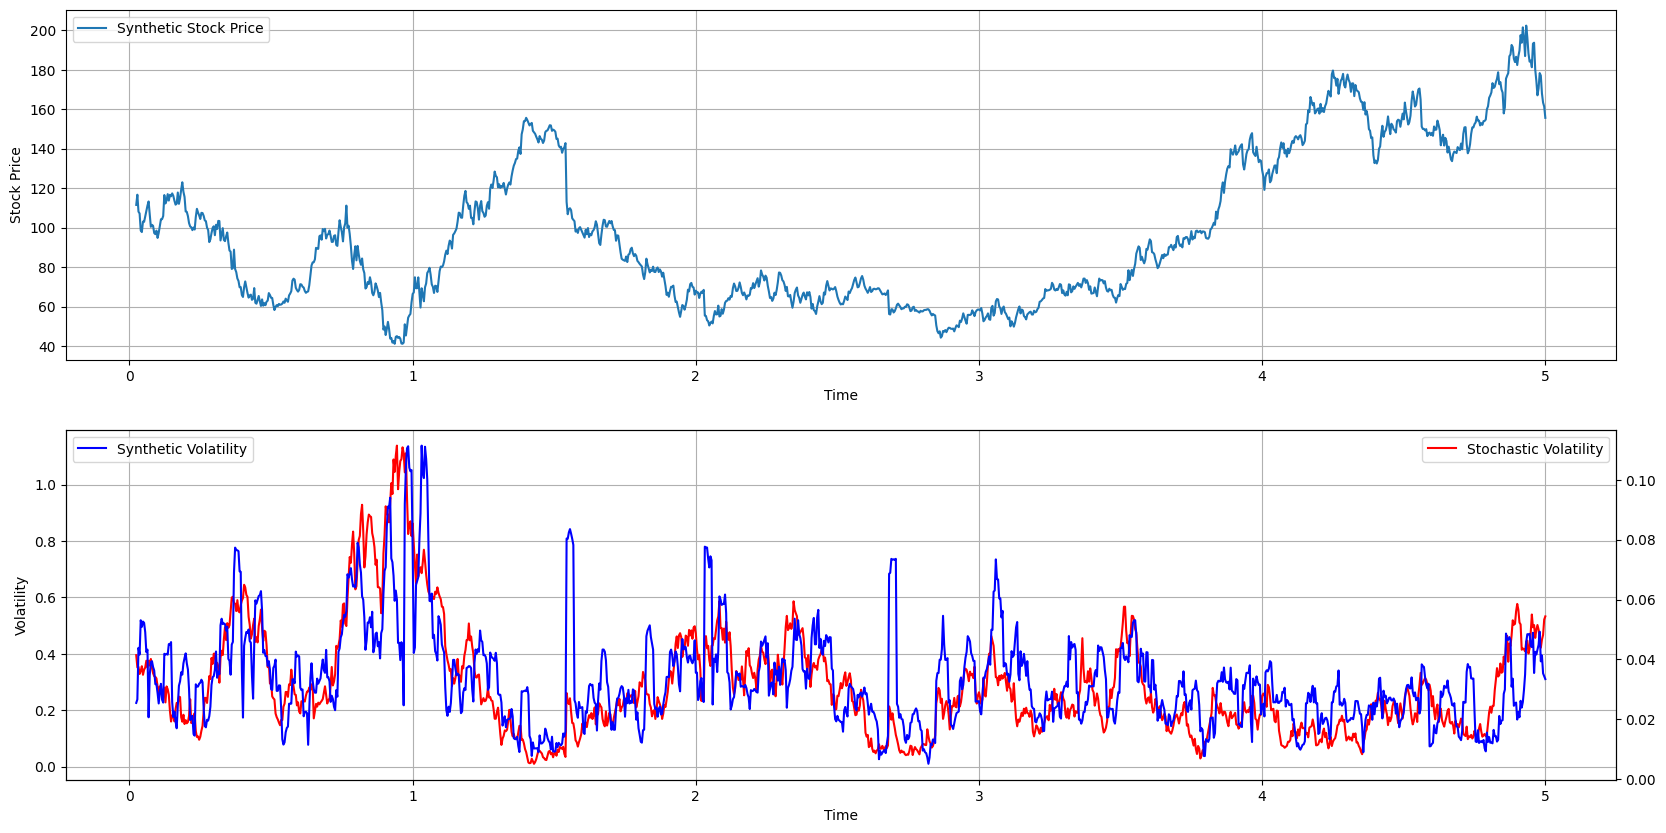

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].plot(df.t, df.prices, label="Synthetic Stock Price")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Stock Price")
ax[0].legend()
ax[0].grid()

ax[1].plot(df.t, df.vol_sto, color="red", label="Stochastic Volatility")
ax_l = ax[1].twinx()
ax_l.plot(df.t, df.vol, color="blue", label="Synthetic Volatility")
ax_l.legend(loc="upper left")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Volatility")
ax[1].legend()
ax[1].grid()


In [ ]:
LEARNABLE_PARAMS = [0.2, 0.02, 0.03, -0.3, 0.07, 0.5] 

In [ ]:
kf_matriciel = LinearKalmanFilterND(
    F=np.array([[1.0]]),
    H=np.array([[1.0]]),
    Q=np.array([[0.5]]),
    R=np.array([[0.5]]),
)

x_hat, P_var, y_hat, V_var = kf_matriciel.fit_predict(
    df.prices.to_numpy().reshape(-1, 1), verbose=False
)

In [ ]:
# Plot the results
plt.figure(figsize=(20, 8))
plt.plot(df.t, df.prices, label="Synthetic Stock Price", alpha=0.5)
plt.plot(df.t, x_hat, label="Kalman Filter State", linestyle="--", color="green")
plt.plot(df.t, y_hat, label="Kalman Filter Estimate", linestyle="--", color="red")
plt.title("Kalman Filter Estimation of Stock Price")
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
kf_matriciel = LinearKalmanFilterND(
    F=np.array([[1.0, 0.0], [0.0, 1.0]]),
    H=np.array([[1.0, 0.0], [0.0, 1.0]]),
    Q=np.array([[1.0, 0.0], [0.0, 1.0]]),
    R=np.array([[1.0, 0.0], [0.0, 1.0]]),
)

x_hat, P_var, y_hat, V_var = kf_matriciel.fit_predict(
    df[["prices", "vol"]].to_numpy(), verbose=False
)

In [ ]:
# Plot the results
plt.figure(figsize=(20, 8))
plt.plot(df.t[50:], df.vol[50:], label="Synthetic Stock Price", alpha=0.5)
plt.plot(
    df.t[50:],
    x_hat[50:, -1],
    label="Kalman Filter State",
    linestyle="--",
    color="green",
)
plt.plot(
    df.t[50:],
    y_hat[50:, -1],
    label="Kalman Filter Estimate",
    linestyle="--",
    color="red",
)
plt.title("Kalman Filter Estimation of Stock Price")
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()

# Let's UKF


In [ ]:
Z = df[["prices", "vol"]].to_numpy()

ukf = UnscentedKalmanFilter(
    dim_x=Z.shape[-1],
    dim_z=Z.shape[-1],
    Q=np.array([[5, 0.0], [0.0, 10]]),
    R=np.array([[5, 0.0], [0.0, 10]]),
)


def f(x, u, v):
    return x + u + v


def h(x, u, n):
    return x + u + n


X_hat, _ = ukf.fit_predict(f, h, Z)


# Plot the results
plt.figure(figsize=(20, 8))
plt.plot(df.t[-100:], df.vol[-100:], label="Synthetic Stock Price", alpha=0.5)
plt.plot(
    df.t[-100:], X_hat[-100:, -1], label="UKF State", linestyle="--", color="green"
)
# plt.plot(df.t[50:], y_hat[50:,-1], label="Kalman Filter Estimate", linestyle="--", color="red")
plt.title("Kalman Filter Estimation of Stock Price")
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()